# Synthetic data

In [1]:
!pwd
import os
os.chdir('..') # for server this isnt reqd
from bilevel.synth_datagen import SynthGenLinear

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/krishna/Documents/Research/Simultaneous Classifier/folktables-experiments/multidecomp/iclr_res


In [2]:
import pickle
def save_ob(name, obj):
    with open(name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_ob(name):
    with open(name, 'rb') as handle:
        obj = pickle.load(handle)
    return obj

In [3]:
def performance_diff(ds_obj):
    df_res = pd.concat([ds_obj.df_base_meansd, ds_obj.df_Anh_meansd], axis=1)
    df_res['base_minus_Anh'] = df_res['mean_base'] - df_res['mean_Anh']
    df_res['discount_from_base'] = (df_res['base_minus_Anh'] / df_res['mean_base'])*100
    return df_res

In [4]:
# # call only one time, used the saved syn_ob below
# params = {'samples': 100000, 'dim':20, 
#         'group_dict': {'SEX':['male', 'female'], 'RACE': ['white', 'black', 'two-or-more','some-other', 'asian', 'native-am']},
#         'prob_dict': {'SEX': [0.5, 0.5], 'RACE': [0.61, 0.12, 0.1, 0.08, 0.06, 0.03]},
#         'feat_lo': 0.0, 'feat_hi': 1.0, 'w_lo': 0.0, 'w_hi': 1.0,
#         'add_linear_mapping': True, 'add_quad_mapping' : False, 
#         'S_lo': 0.0, 'S_hi':0.0,
#         'label_noise_width':0.16, 'drop_sensitive':False, 'fixed_seed':42,
#         }
# syn_ob = SynthGenLinear(**params)
# print(syn_ob.dperm, np.array(syn_ob.all_groupnames)[syn_ob.dperm])
# df = syn_ob.df
params = {'samples': 100000, 'dim':20, 
        'group_dict': {'SHAPE':['circle', 'square', 'triangle'], 'COLOR': ['green', 'red']},
        'prob_dict': {'SHAPE': [0.5, 0.3, 0.2], 'COLOR': [0.6, 0.4]},
        'feat_lo': 0.0, 'feat_hi': 1.0, 'w_lo': 0.0, 'w_hi': 1.0,
        'add_linear_mapping': True, 'add_quad_mapping' : False,
        'S_lo': 0.0, 'S_hi':0.0,
        'label_noise_width':0.16, 'drop_sensitive':False, 'fixed_seed':21,
        }
syn_ob = SynthGenLinear(**params)
print(syn_ob.dperm, np.array(syn_ob.all_groupnames)[syn_ob.dperm])
df = syn_ob.df

[3 1 4 2 0] ['green' 'square' 'red' 'triangle' 'circle']


In [5]:
save_ob('syn_neutral_2sg_exploss_.pickle', syn_ob)

In [6]:
print(df.columns)
filter_feature = [col for col in df if col.startswith('x')]
filter_label = [col for col in df if col.startswith('y')]
filter_group = [col for col in df if col.startswith('g')]
print(filter_feature, filter_label, filter_group)

Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9',
       'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18',
       'x_19', 'g_circle', 'g_square', 'g_triangle', 'g_green', 'g_red',
       'y_circle', 'y_square', 'y_triangle', 'y_green', 'y_red',
       'y_mean_active', 'y_min_active', 'y_max_active', 'y_dperm_active'],
      dtype='object')
['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19'] ['y_circle', 'y_square', 'y_triangle', 'y_green', 'y_red', 'y_mean_active', 'y_min_active', 'y_max_active', 'y_dperm_active'] ['g_circle', 'g_square', 'g_triangle', 'g_green', 'g_red']


## Note about features and labels
- x_0...x_19 are the features, y_mean, min, max, dperm are the labels
- also include group membership in features!, group memberships are
    Race groups, Sex groups

In [8]:
syn_ob.A_t.shape

(100000, 5)

In [9]:
syn_ob.A_t.sum(axis=0), syn_ob.all_groupnames

(array([49857., 30044., 20099., 59985., 40015.]),
 ['circle', 'square', 'triangle', 'green', 'red'])

In [10]:
A_t = pd.DataFrame(syn_ob.A_t, columns = syn_ob.all_groupnames) # A_t dataframe
A_t['always_on'] = 1

In [11]:
A_t.sum(axis=0)

circle        49857.0
square        30044.0
triangle      20099.0
green         59985.0
red           40015.0
always_on    100000.0
dtype: float64

In [12]:
df_mean = df[filter_feature+filter_group + ['y_mean_active']]
df_min = df[filter_feature+filter_group + ['y_min_active']]
df_max = df[filter_feature+filter_group + ['y_max_active']]
df_dperm = df[filter_feature+filter_group + ['y_dperm_active']]

In [13]:
from bilevel.Groupwise_seedruns import BuildGroupwise_diffseeds

## y_mean

In [14]:
%%time
ds_ymean = BuildGroupwise_diffseeds(df_mean, 'y_mean_active', A_t) # different seeds object
ds_ymean.build_all_seeds()
ds_ymean.build_df_res()
ds_ymean.build_regret_curve()

100%|██████████| 100000/100000 [00:12<00:00, 7743.15it/s]


CPU times: user 5min 28s, sys: 6.95 s, total: 5min 35s
Wall time: 2min 58s


In [15]:
save_ob('syn_ymean_2sg_exploss.pickle', ds_ymean)

## y_min

In [16]:
%%time
ds_ymin = BuildGroupwise_diffseeds(df_min, 'y_min_active', A_t) # different seeds object
ds_ymin.build_all_seeds()
ds_ymin.build_df_res()
ds_ymin.build_regret_curve()

100%|██████████| 100000/100000 [00:13<00:00, 7658.58it/s]


CPU times: user 5min 32s, sys: 7.15 s, total: 5min 39s
Wall time: 3min 2s


In [17]:
save_ob('syn_ymin_2sg_exploss.pickle', ds_ymin)

In [19]:
# pd.concat([ds_ymin.df_base_meansd, ds_ymin.df_Anh_meansd], axis=1)

## y_max

In [18]:
ds_ymax = BuildGroupwise_diffseeds(df_max, 'y_max_active', A_t) # different seeds object
ds_ymax.build_all_seeds()
ds_ymax.build_df_res()
ds_ymax.build_regret_curve()

100%|██████████| 100000/100000 [00:13<00:00, 7616.19it/s]


In [19]:
save_ob('syn_ymax_2sg_exploss.pickle', ds_ymax)

## y_dperm

In [20]:
ds_ydperm = BuildGroupwise_diffseeds(df_dperm, 'y_dperm_active', A_t) # different seeds object
ds_ydperm.build_all_seeds()
ds_ydperm.build_df_res()
ds_ydperm.build_regret_curve()

100%|██████████| 100000/100000 [00:13<00:00, 7601.97it/s]


In [21]:
save_ob('syn_ydperm_2sg_exploss.pickle', ds_ydperm)

In [23]:
# ds_ydperm.regret_Base_groupwise_array[-1].mean(axis=0), ds_ydperm.regret_Anh_groupwise_array[-1].mean(axis=0)

## checks which aggregation is the best for Anh

In [24]:
performance_diff(ds_ymean)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
circle,38.823136,0.228843,24.297084,0.093711,14.526052,37.415968
square,29.557648,0.137492,14.755571,0.061098,14.802077,50.078670
triangle,21.563486,0.109478,10.193406,0.042556,11.370079,52.728393
green,48.822839,0.158374,24.673172,0.203241,24.149668,49.463874
red,41.121430,0.164090,24.572889,0.175006,16.548541,40.243106
always_on,89.944269,0.061214,49.246061,0.104713,40.698209,45.248251


In [25]:
performance_diff(ds_ymin)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
circle,85.110057,0.290209,64.295158,0.101725,20.814899,24.456451
square,79.376965,0.326899,16.110335,0.049539,63.266630,79.704018
triangle,38.841274,0.141856,26.941467,0.068696,11.899806,30.637014
green,111.968032,0.199716,54.315752,0.237158,57.652279,51.489946
red,91.360264,0.213556,53.031208,0.241434,38.329056,41.953749
always_on,203.328296,0.059384,107.346960,0.089883,95.981335,47.205105


In [26]:
performance_diff(ds_ymax)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
circle,55.237146,0.341842,33.372373,0.072752,21.864773,39.583459
square,54.771877,0.149721,37.437832,0.082090,17.334045,31.647711
triangle,38.929435,0.233634,10.290950,0.053193,28.638486,73.565120
green,74.031198,0.217122,42.135148,0.251334,31.896050,43.084606
red,74.907260,0.233326,38.966006,0.305134,35.941254,47.981002
always_on,148.938458,0.078649,81.101154,0.131456,67.837304,45.547204


In [5]:
performance_diff(ds_ydperm)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
circle,105.977321,0.470882,38.508820,0.184317,67.468501,63.663150
square,146.969978,0.668955,54.586544,0.287178,92.383434,62.858711
triangle,42.698178,0.208526,15.521383,0.092719,27.176796,63.648607
green,104.842442,0.934529,30.258582,0.073942,74.583859,71.138995
red,190.803035,0.922476,78.358164,0.274851,112.444871,58.932433
always_on,295.645477,0.094747,108.616746,0.263066,187.028730,63.261151


In [4]:
ds_ymean = load_ob('syn_ymean_2sg_exploss.pickle')
ds_ymin = load_ob('syn_ymin_2sg_exploss.pickle')
ds_ymax = load_ob('syn_ymax_2sg_exploss.pickle')
ds_ydperm = load_ob('syn_ydperm_2sg_exploss.pickle')

In [5]:
from bilevel.Groupwise_seedruns import get_end_regret_gw_df
df_regend_ymin = get_end_regret_gw_df(ds_ymin)
df_regend_ymean = get_end_regret_gw_df(ds_ymean)
df_regend_ymax = get_end_regret_gw_df(ds_ymax)
df_regend_ydperm = get_end_regret_gw_df(ds_ydperm)

In [25]:
df_regend_ymin.to_csv('dfregend_synth_2sg_ymin.csv')
df_regend_ymean.to_csv('dfregend_synth_2sg_ymean.csv')
df_regend_ymax.to_csv('dfregend_synth_2sg_ymax.csv')
df_regend_ydperm.to_csv('dfregend_synth_2sg_ydperm.csv')

In [31]:
# also check that df mean, min, max, dperm are same except ycol

circle 49857


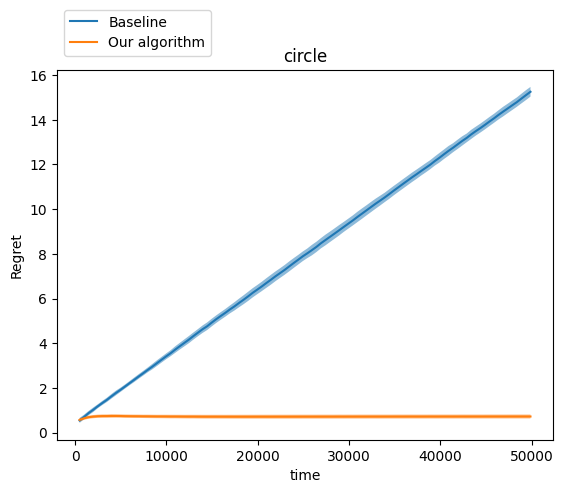

square 30044


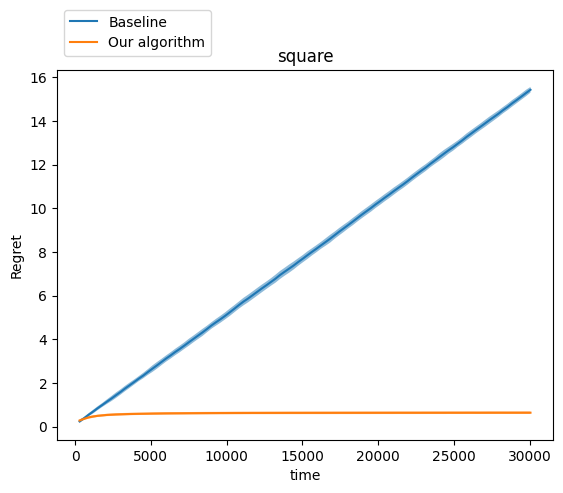

triangle 20099


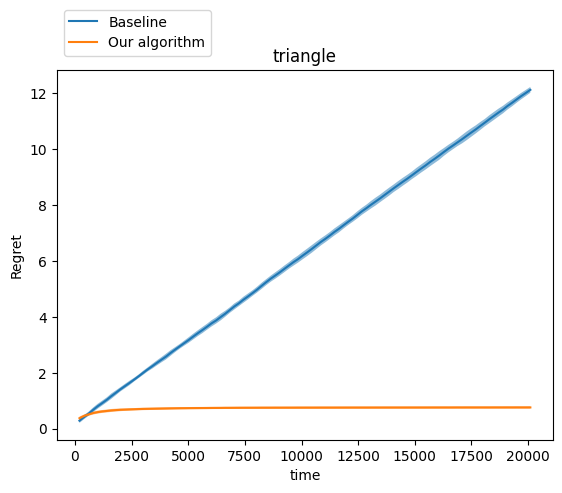

green 59985


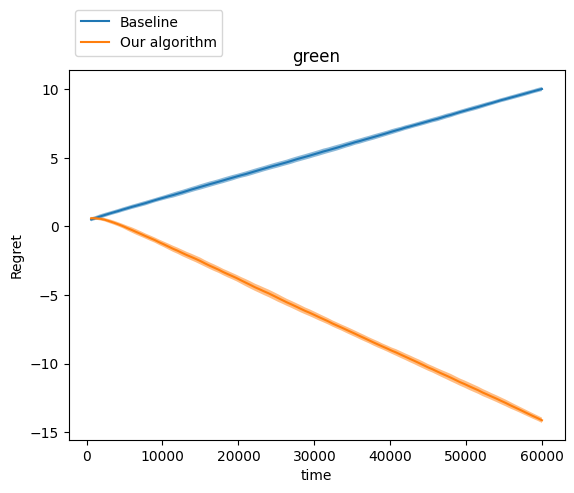

red 40015


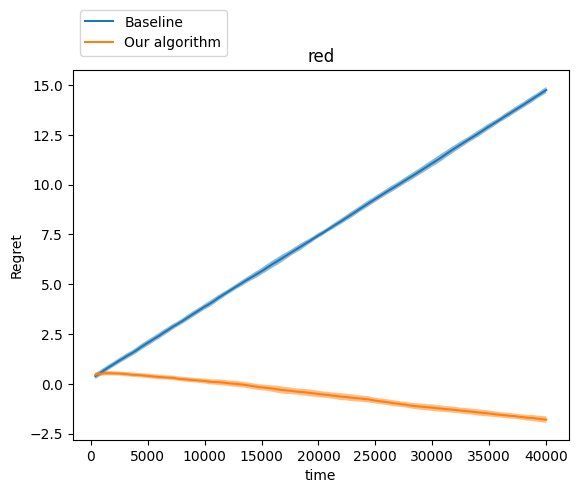

always_on 100000


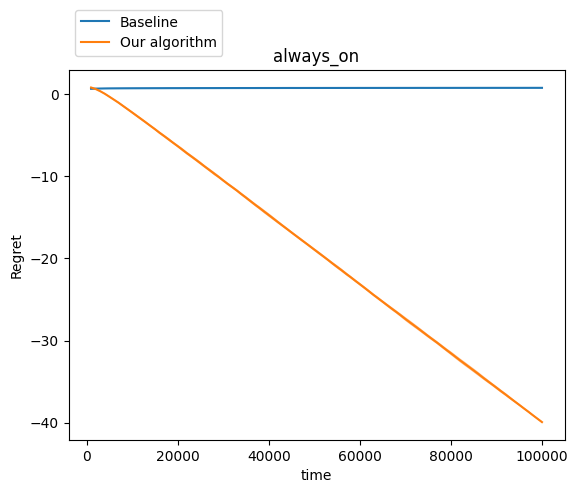

circle 49857


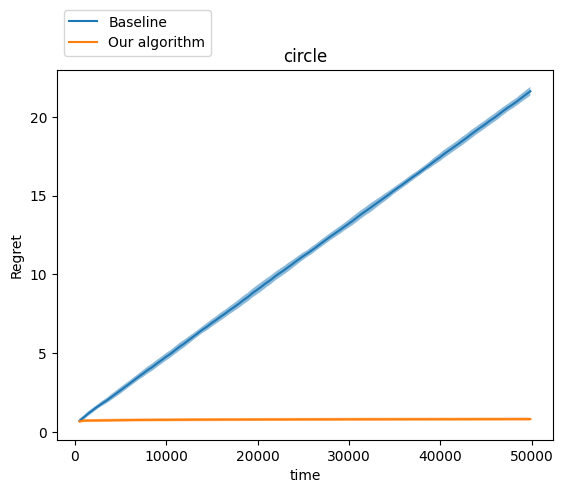

square 30044


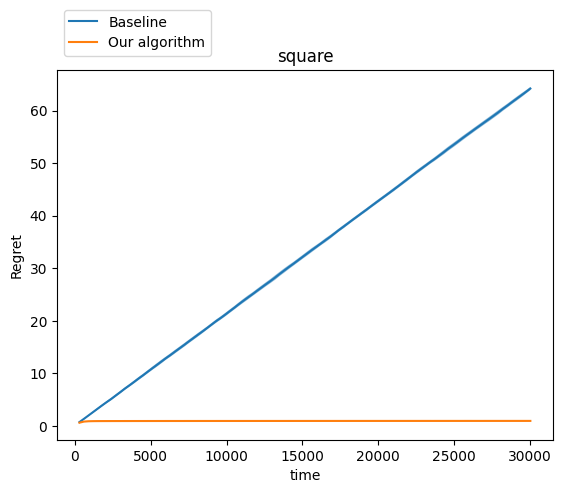

triangle 20099


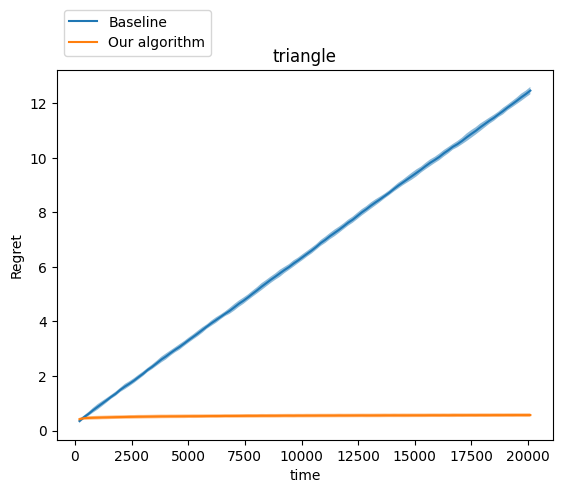

green 59985


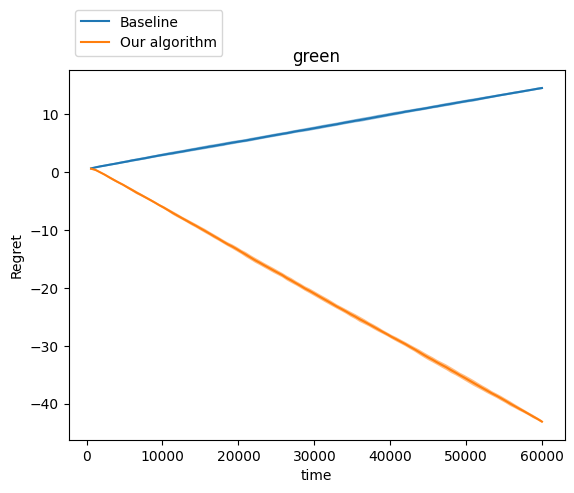

red 40015


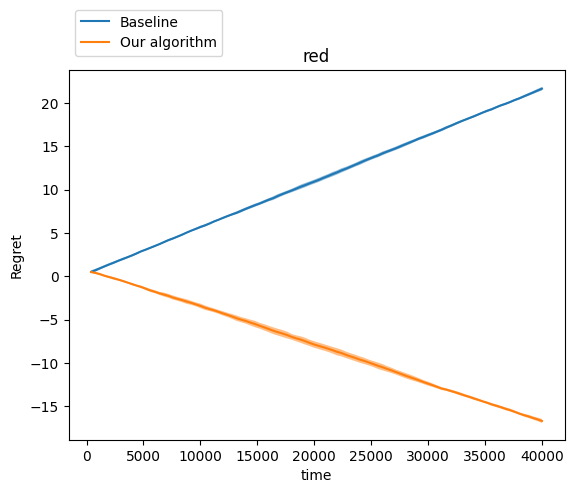

always_on 100000


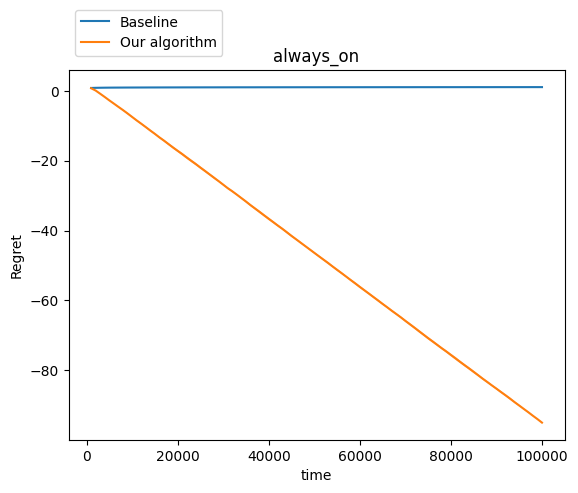

circle 49857


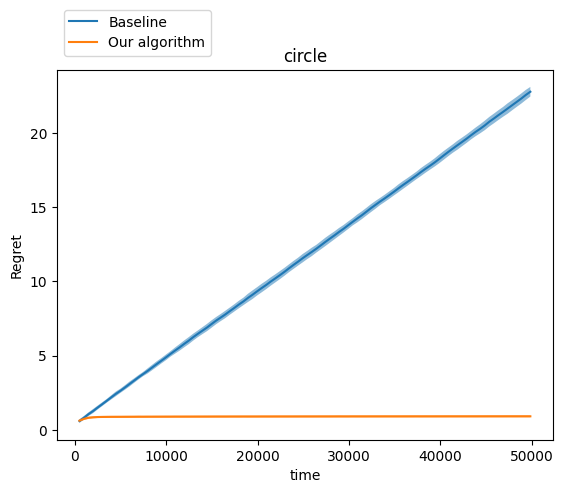

square 30044


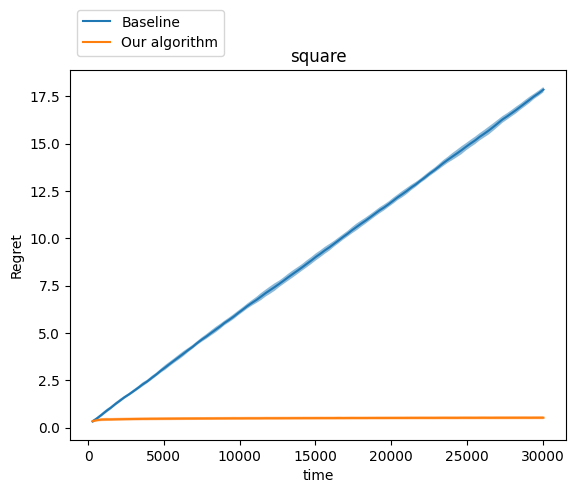

triangle 20099


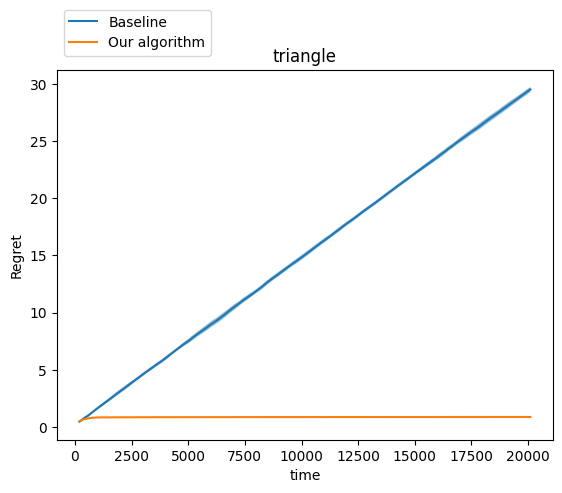

green 59985


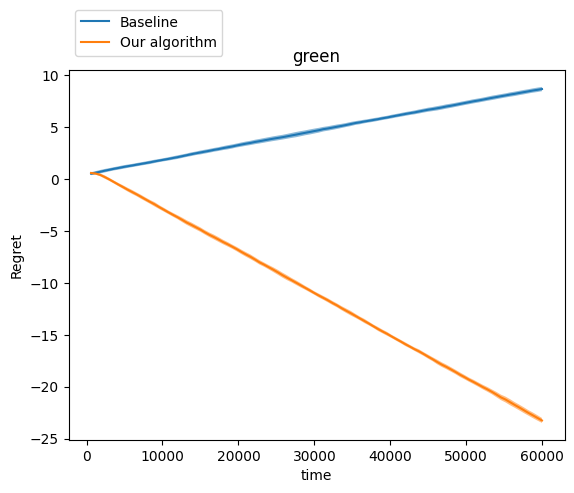

red 40015


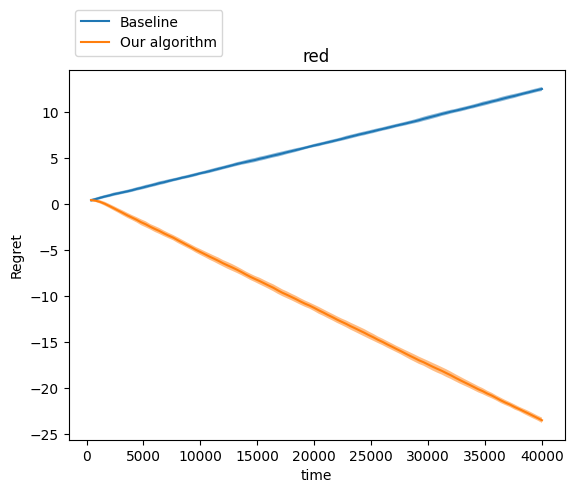

always_on 100000


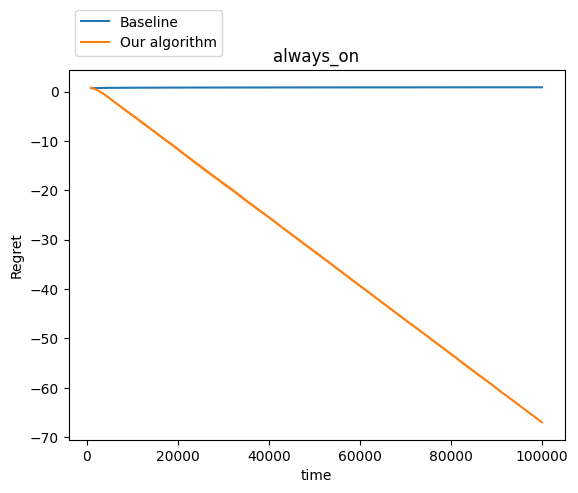

circle 49857


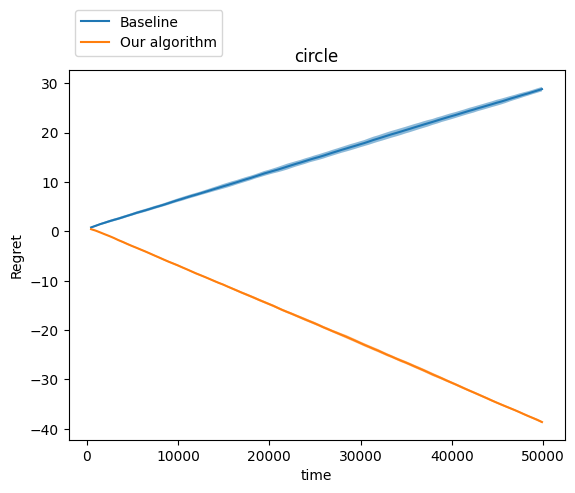

square 30044


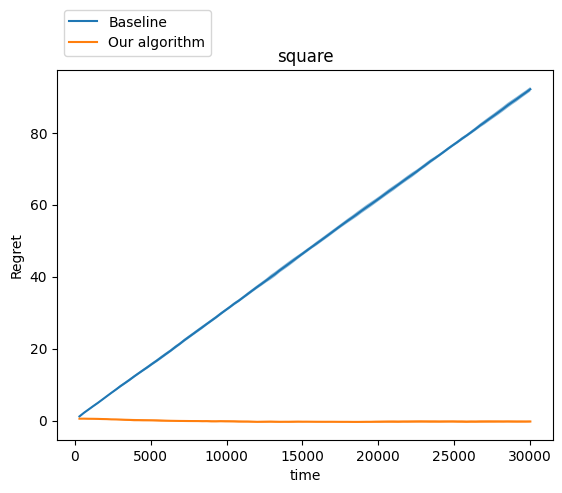

triangle 20099


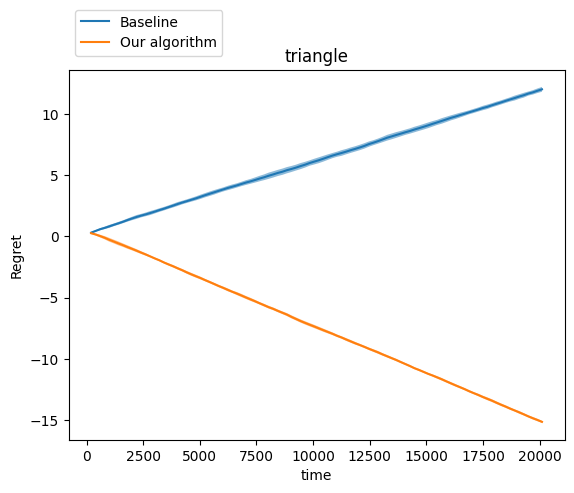

green 59985


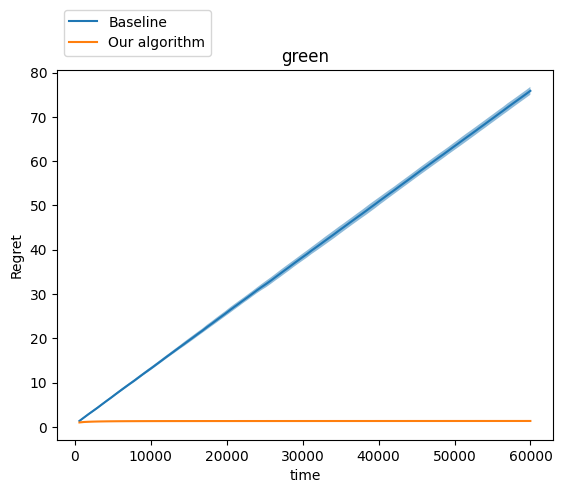

red 40015


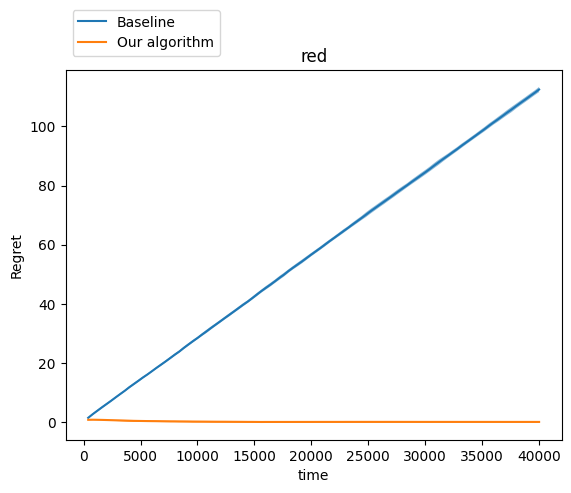

always_on 100000


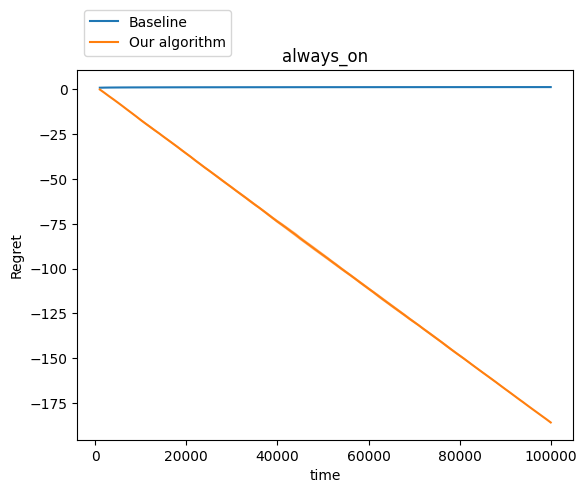

In [6]:
from bilevel.Groupwise_seedruns import plot_regret_curve_with_std
# ds_ymean = load_ob('syn_ymean_seeds.pickle')
plot_regret_curve_with_std(ds_ymean, 'synth_ymean')

# ds_ymin = load_ob('syn_ymin_seeds.pickle')
plot_regret_curve_with_std(ds_ymin, 'synth_ymin')

# ds_ymax = load_ob('syn_ymax_seeds.pickle')
plot_regret_curve_with_std(ds_ymax, 'synth_ymax')


# ds_ydperm = load_ob('syn_ydperm_seeds.pickle')
plot_regret_curve_with_std(ds_ydperm, 'synth_ydperm')

In [29]:
recs = []
for gnum, gname in enumerate(ds_ymean.group_names):
    print(gname, ds_ymean.group_sizes[gnum])
    recs.append([gname,ds_ymean.regret_Base_groupwise_array[gnum].mean(axis=0)[-1], ds_ymean.regret_Anh_groupwise_array[gnum].mean(axis=0)[-1]])

circle 49857
square 30044
triangle 20099
green 59985
red 40015
always_on 100000


In [30]:
recs

[['circle', 15.251997110388576, 0.7259449314606489],
 ['square', 15.434646792583441, 0.6325698318397185],
 ['triangle', 12.129030335953217, 0.7589509662176225],
 ['green', 10.017408486535388, -14.132259299839756],
 ['red', 14.751903858956979, -1.796636864075213],
 ['always_on', 0.7638470011019237, -39.93436150830535]]

In [31]:
pd.DataFrame(recs, columns = ['group', 'base', 'Anh'])

,group,base,Anh
0,circle,15.251997,0.725945
1,square,15.434647,0.632570
2,triangle,12.129030,0.758951
3,green,10.017408,-14.132259
4,red,14.751904,-1.796637
5,always_on,0.763847,-39.934362


In [32]:
from bilevel.Groupwise_seedruns import get_end_regret_gw_df
get_end_regret_gw_df(ds_ymean)

,group_name,mean_regend_Base,std_regend_Base,mean_regend_Anh,std_regend_Anh
0,circle,15.251997,0.217232,0.725945,0.089117
1,square,15.434647,0.130383,0.632570,0.057960
2,triangle,12.129030,0.104111,0.758951,0.040418
3,green,10.017408,0.150368,-14.132259,0.192891
4,red,14.751904,0.155782,-1.796637,0.166137
5,always_on,0.763847,0.058121,-39.934362,0.099225
